In [1]:
!pwd

/mnt/c/Users/sahaC/Desktop/side_project/molssi_best_practices/CRISP_Paper_Calculations/Workflow_example


In [2]:
import CRISP
import re
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [3]:
import time
notebook_start_time = time.time()

# Error Analysis

/tmp/ipykernel_10703/1222050882.py:6: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



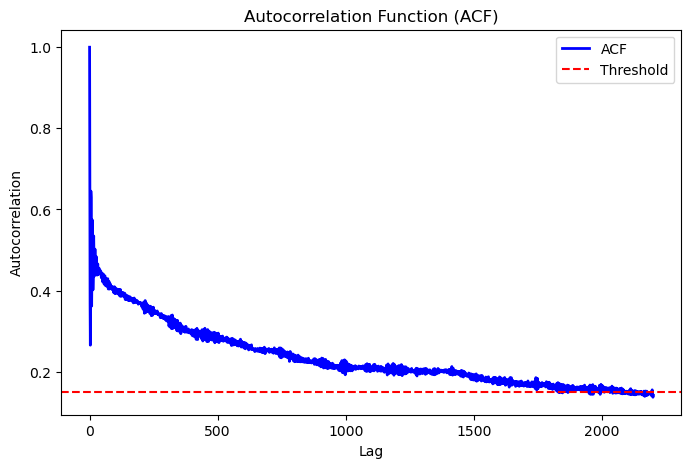

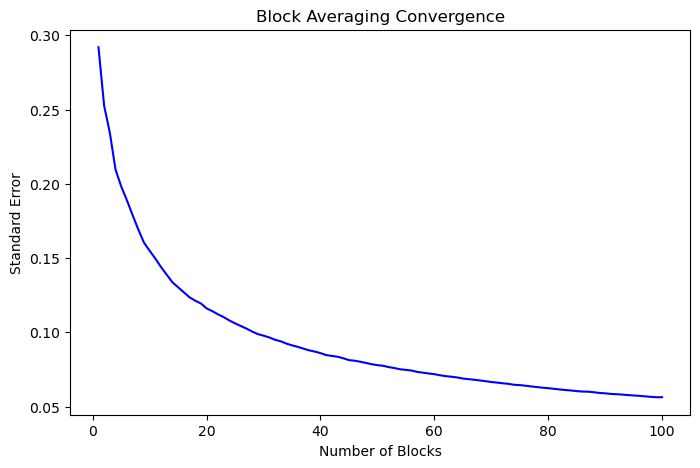

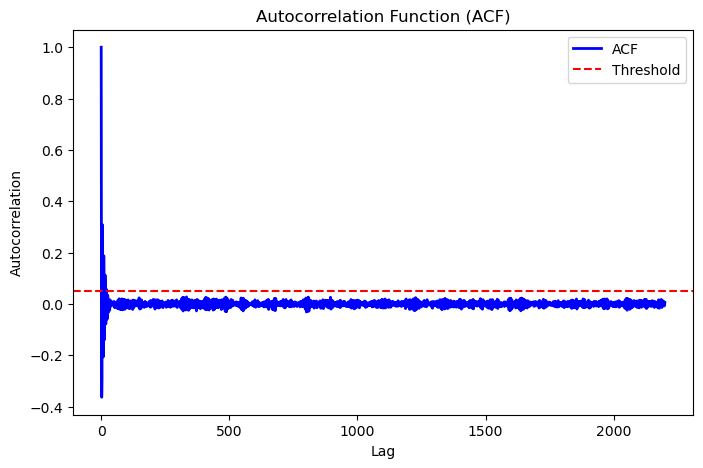

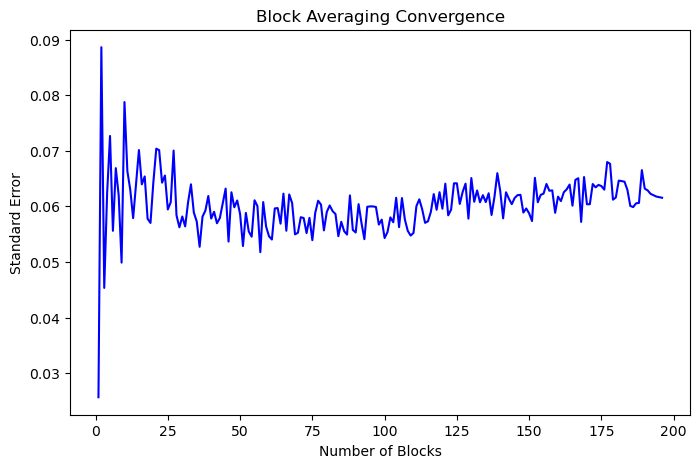

In [4]:
from CRISP.simulation_utility.error_analysis import error_analysis

output_dir = "./Simulation_Utility/md_error_analysis"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv("./al_12_48h2o/nvt_eq.log", delim_whitespace=True)

epot_data = df["Epot[eV]"].values
temp_data = df["T[K]"].values
max_lag = min(2200, len(df))

epot_results = error_analysis(epot_data, max_lag, threshold=0.15, plot=True)
plt.savefig(f"{output_dir}/epot_analysis.png", dpi=300)

temp_results = error_analysis(temp_data, max_lag, plot=True)
plt.savefig(f"{output_dir}/temp_analysis.png", dpi=300)



# Atomic Indices

In [5]:
from CRISP.simulation_utility.atomic_indices import run_atom_indices


file_path = "./al_12_48h2o/nvt_eq.traj"
output_folder = './Simulation_Utility/indices_new'

run_atom_indices(file_path, output_folder, frame_index=1,
                 custom_cutoffs = {('O', 'Al'): 2.0,  # Framework O-Al cutoff
                                   ('O', 'Si'): 2.0,  # Framework O-Si cutoff
                                   ('H', 'O'): 1.2})   # Basic H-O cutoff for water
                                


Analyzing frame with index 1 (out of 21000 frames)
Length of Al indices: 12
Length of Si indices: 36
Length of H indices: 108
Length of O indices: 144
Outputs saved.
Saved cutoff indices for O-Al to ./Simulation_Utility/indices_new/cutoff/O-Al_cutoff.csv
Saved cutoff indices for O-Si to ./Simulation_Utility/indices_new/cutoff/O-Si_cutoff.csv
Saved cutoff indices for H-O to ./Simulation_Utility/indices_new/cutoff/H-O_cutoff.csv


# Subsampling

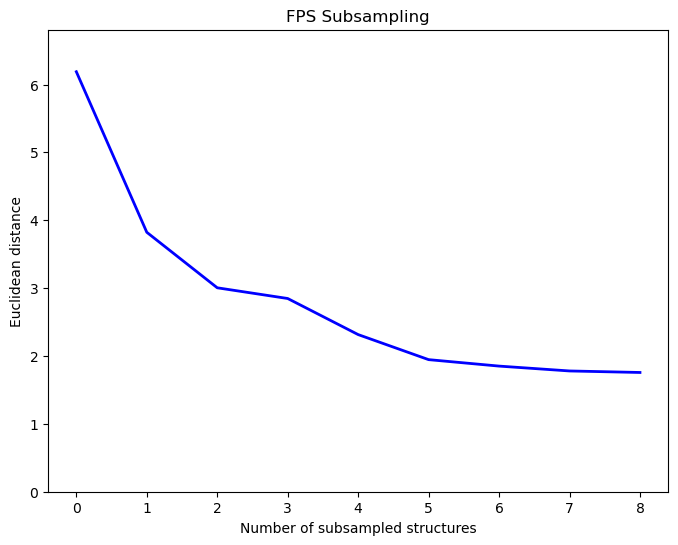

Saved convergence plot to ./Simulation_Utility/md_subsampling_analysis/subsampled_convergence.png
Saved 10 subsampled structures to ./Simulation_Utility/md_subsampling_analysis/subsample_nvt_eq.traj


In [6]:
from CRISP.simulation_utility.subsampling import subsample

all_frames = subsample(
    traj_path="./al_12_48h2o/nvt_eq.traj",           
    n_samples=10,                  
    plot_subsample=True, 
    frame_skip=100,
    output_dir="./Simulation_Utility/md_subsampling_analysis"       
)

# MSD

In [7]:
from CRISP.data_analysis.msd import calculate_save_msd   

file_path = "./al_12_48h2o/nvt_eq.traj"
indices_file = './Simulation_Utility/indices_new_detailed/water_oxygen_indices.npy'
timestep = 0.5 * 100 * 100
frame_skip=100

msd_values, msd_times = calculate_save_msd(
    traj_path=file_path,
    timestep_fs=timestep,
    indices_path=indices_file,
    frame_skip=frame_skip,
    output_dir="./Data_Analysis/MSD",
    output_file='./msd_results_water.csv'
)


Loaded 210 frames after applying frame_skip=100
Loaded 48 atom indices
Using timestep: 5000.0 fs
Calculating MSD using parallel processing...
MSD data has been saved to ./Data_Analysis/MSD/msd_results_water.csv


Total data points in file: 210
Loaded MSD data from ./Data_Analysis/MSD/msd_results_water.csv


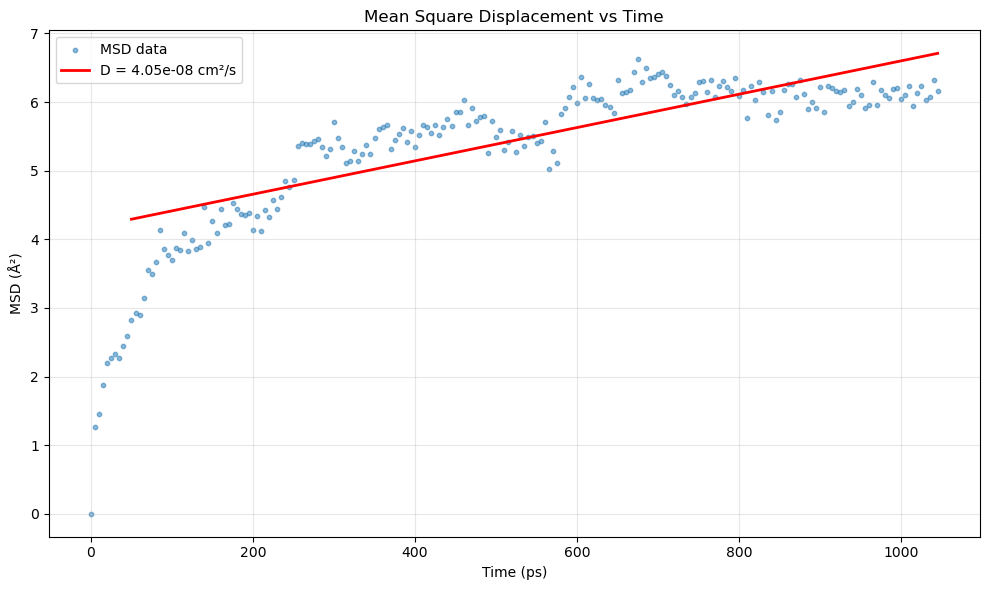

Diffusion Coefficient: 4.05e-08 cm²/s
Error in the Fit: 1.84e-09 cm²/s

MSD Analysis Results (Standard Fit):
Diffusion Coefficient: D = 4.0498e-08 ± 1.8434e-09 cm²/s (4.6%)


In [8]:
from CRISP.data_analysis.msd import analyze_from_csv

df = pd.read_csv("./Data_Analysis/MSD/msd_results_water.csv")
print(f"Total data points in file: {len(df)}")

D, error  = analyze_from_csv(
    csv_file="./Data_Analysis/MSD/msd_results_water.csv",
    fit_start=10,
    fit_end=len(df),  
    with_intercept=True,
    plot_msd=True)



# Coordination Number

In [9]:
from CRISP.data_analysis.contact_coordination import coordination

file_path = "./al_12_48h2o/nvt_eq.traj"
indices_file = './Simulation_Utility/indices_new_detailed/water_oxygen_indices.npy'
output_dir = "./Data_Analysis/Water_CN_data"

os.makedirs(output_dir, exist_ok=True)

water_oxygen_indices = np.load(indices_file)
print(f"Loaded {len(water_oxygen_indices)} water oxygen indices")

custom_cutoffs = {('O', 'O'): 3.0}  # 3.0 Å cutoff for O-O interactions

cn_all = coordination(
    traj_path=file_path,
    central_atoms=indices_file,   
    target_atoms=indices_file,                  
    custom_cutoffs=custom_cutoffs,
    frame_skip=100,
    output_dir=output_dir)



Loaded 48 water oxygen indices
Coordination statistics saved to ./Data_Analysis/Water_CN_data/CN_water_oxygen_indices_statistics.txt

Coordination Statistics Summary:
CN=0: 1.98% ± 0.49%
CN=1: 2.66% ± 2.52%
CN=2: 30.29% ± 5.84%
CN=3: 52.61% ± 6.17%
CN=4: 12.31% ± 3.93%
CN=5: 0.15% ± 0.61%

Most common coordination number: 3

Average Coordination Number: 2.71 ± 0.80


# RDF

In [10]:
from CRISP.data_analysis.prdf import analyze_rdf

# Total

In [11]:
result = analyze_rdf(
    use_prdf=False,
    rmax=6,
    traj_path="./al_12_48h2o/nvt_eq.traj",
    nbins=50,
    frame_skip=100,
    output_filename=None,  
    output_dir="./Data_Analysis/RDF/Total")



Data saved in './Data_Analysis/RDF/Total/rdf_total.pkl'


# goo

In [12]:
o_indices = np.load('./Simulation_Utility/indices_new/O_indices.npy')

# For PRDF between oxygen atoms, we use the same indices for both reference and target
atomic_indices = (o_indices.tolist(), o_indices.tolist())


result = analyze_rdf(
    use_prdf=True,
    rmax=6,
    traj_path="./al_12_48h2o/nvt_eq.traj",
    nbins=50,
    frame_skip=100,
    output_filename=None,  
    atomic_indices=atomic_indices,
    output_dir="./Data_Analysis/RDF/Partial/goo")




Data saved in './Data_Analysis/RDF/Partial/goo/prdf_144-atoms_144-atoms.pkl'


# goh

In [13]:
# Load oxygen and hydrogen indices from the .npy file
o_indices = np.load('./Simulation_Utility/indices_new/O_indices.npy')
h_indices = np.load('./Simulation_Utility/indices_new/H_indices.npy')

# For PRDF between hydrogen atoms, we use the same indices for both reference and target
atomic_indices = (o_indices.tolist(), h_indices.tolist())


result = analyze_rdf(
    use_prdf=True,
    rmax=6,
    traj_path="./al_12_48h2o/nvt_eq.traj",
    nbins=50,
    frame_skip=100,
    output_filename=None,  
    atomic_indices=atomic_indices,
    output_dir="./Data_Analysis/RDF/Partial/goh")




Data saved in './Data_Analysis/RDF/Partial/goh/prdf_144-atoms_108-atoms.pkl'


# ghh

In [14]:
# Load oxygen indices from the .npy file
h_indices = np.load('./Simulation_Utility/indices_new/H_indices.npy')

# For PRDF between hydrogen atoms, we use the same indices for both reference and target
atomic_indices = (h_indices.tolist(), h_indices.tolist())

result = analyze_rdf(
    use_prdf=True,
    rmax=6,
    traj_path="./al_12_48h2o/nvt_eq.traj",
    nbins=50,
    frame_skip=100,
    output_filename=None,  
    atomic_indices=atomic_indices,
    output_dir="./Data_Analysis/RDF/Partial/ghh")


Data saved in './Data_Analysis/RDF/Partial/ghh/prdf_108-atoms_108-atoms.pkl'


# Hydrogen bond

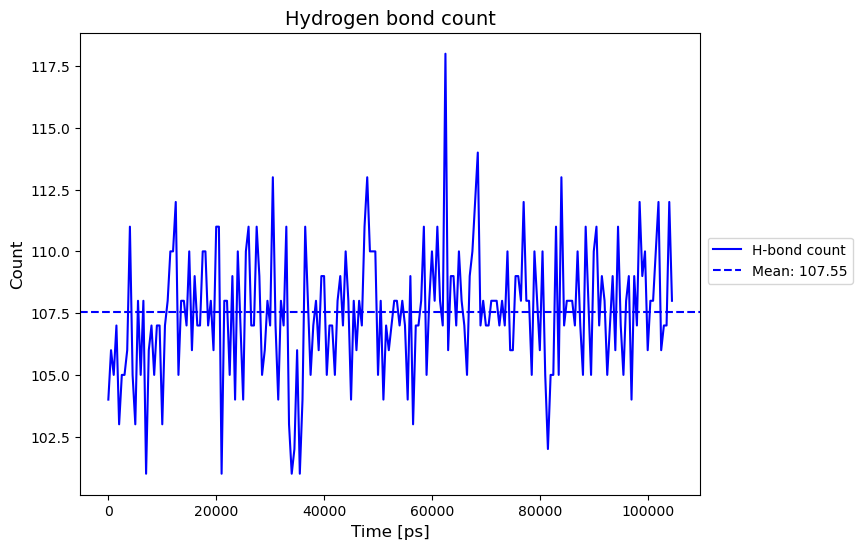

Hydrogen bond count plot saved to './Data_Analysis/HBond/h_bond_count.png'


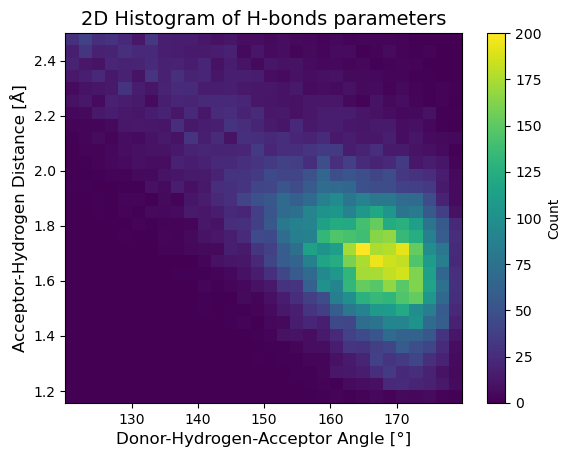

H-bond structure 2D histogram saved to './Data_Analysis/HBond/h_bond_structure.png'
Generated and saved 131 unique donor/acceptor atom indices to ./Data_Analysis/HBond/donor_acceptor_indices.npy
Generating hydrogen bond network visualizations for frame 0...
Interactive correlation matrix saved as './Data_Analysis/HBond/hbond_correlation_matrix_frame_0.html'
Figure saved as './Data_Analysis/HBond/hbond_network_frame_0.html'


In [15]:
from CRISP.data_analysis.h_bond import hydrogen_bonds, indices

frame_skip = 100  
angle_cutoff = 120  
h_bond_cutoff = 2.5  
bond_cutoff = 1.6  
time_step = 0.5*100*100  


traj_path="./al_12_48h2o/nvt_eq.traj"
output_dir = "./Data_Analysis/HBond"

os.makedirs(output_dir, exist_ok=True)


h_bonds_per_frame = hydrogen_bonds(
    traj_path=traj_path,
    frame_skip=frame_skip,
    acceptor_atoms=["O"],  
    angle_cutoff=angle_cutoff,
    h_bond_cutoff=h_bond_cutoff,
    bond_cutoff=bond_cutoff,
    time_step=time_step,
    mic=True,
    output_dir=output_dir,
    plot_count=True,
    plot_heatmap=True,
    plot_graph_frame=True,
    graph_frame_index=0
)


In [16]:
print(f"Total notebook execution time: {time.time() - notebook_start_time:.2f} seconds")

Total notebook execution time: 124.35 seconds
